In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mppi import InputFiles as I, Calculators as C, Datasets as D

In [2]:
omp = 1
mpi_run = 'mpirun -np 8'

# Nscf on a grid - Ypp bands

In this nb we perform (several) nscf computation on a regular grid and reproduce the ks bands using ypp. In this way we can perform a check on the dimension of the k grid that will be used in the subsequent yambo real time computations. 

This framework allows us also to use yambo scissor to open the ks band-gap.

## Nscf on a regular grid

We define the basic elements of the input

In [3]:
input = I.PwIn()
Ga = [0.,0.,0.]
As = [0.25,0.25,0.25]

input.set_pseudo_dir('../pseudos')
input.set_calculation('nscf')

input.set_occupations('fixed')
input.system['ibrav'] = 2
input.system['celldm(1)'] = 10.677
input.system['noncolin'] = '.true'
input.system['lspinorb'] = '.true'
input.set_atoms_type(2)
input.set_atoms_number(2)
input.set_atoms_position(pos_type='crystal',pos_list=[['Ga',Ga],['As',As]])
input.atypes = {'Ga': [69.72,'Ga_rel.pz-rrkj3.UPF'],\
                'As': [74.92,'As_rel.pz-rrkj3.UPF']}
input.set_convergence_thr(1e-8)

On this basis of the gs_convergence analysis previously performed we choose the scf converged parameters:

In [4]:
k_conv = 6
ecut_conv = 80

and we perform the nscf computations using a number of bands given by:

In [5]:
numBands = 40

In [6]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,executable='pw.x',verbose=True,skip=True)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 8 pw.x


We perform nscf computation on grids of various dimensions. The simulations are organized in a dataset

In [5]:
nscf_kvalues = [4,6,8,10]

In [8]:
bnds_study = D.Dataset(label='nscf',run_dir='nscf',pre_processing='nscf')

In [9]:
input.system['nbnd'] = numBands
for k  in nscf_kvalues:
    idd = {'bnds' : numBands, 'kpoints' : k} 
    input.set_prefix(D.name_from_id(idd))
    input.set_energy_cutoff(ecut_conv)
    input.set_kpoints(ktype='automatic',kpoints=[k,k,k])
    bnds_study.append_run(id=idd,calculator=code,input=input)

Apply the pre-processing

In [12]:
source = 'gs_convergence/ecut_%s-k_%s.save'%(ecut_conv,k_conv)

In [13]:
bnds_study.pre_processing_function(source_dir=source)

Folder nscf already exists
execute :  cp -r gs_convergence/ecut_80-k_6.save nscf/bnds_40-kpoints_4.save
execute :  cp -r gs_convergence/ecut_80-k_6.save nscf/bnds_40-kpoints_6.save
execute :  cp -r gs_convergence/ecut_80-k_6.save nscf/bnds_40-kpoints_8.save
execute :  cp -r gs_convergence/ecut_80-k_6.save nscf/bnds_40-kpoints_10.save


In [14]:
bnds_study.run()

execute : cd nscf ; OMP_NUM_THREADS=1 mpirun -np 8 pw.x -inp bnds_40-kpoints_4.in > bnds_40-kpoints_4.log
parse file : nscf/bnds_40-kpoints_4.save/data-file-schema.xml
execute : cd nscf ; OMP_NUM_THREADS=1 mpirun -np 8 pw.x -inp bnds_40-kpoints_6.in > bnds_40-kpoints_6.log
parse file : nscf/bnds_40-kpoints_6.save/data-file-schema.xml
execute : cd nscf ; OMP_NUM_THREADS=1 mpirun -np 8 pw.x -inp bnds_40-kpoints_8.in > bnds_40-kpoints_8.log
parse file : nscf/bnds_40-kpoints_8.save/data-file-schema.xml
execute : cd nscf ; OMP_NUM_THREADS=1 mpirun -np 8 pw.x -inp bnds_40-kpoints_10.in > bnds_40-kpoints_10.log
parse file : nscf/bnds_40-kpoints_10.save/data-file-schema.xml


## Ypp bands

The band structure can be extracted from the nscf computation on a grid using ypp. 

For each choice of the nscf .save folder we have a different dataset (each of which will be composed by only one computation)

In [6]:
code = C.YamboCalculator(omp=1,mpi_run='mpirun -np 1',executable='ypp',suffix='bands_interpolated',skip=False)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 1 ypp
Suffix for post_processing :  bands_interpolated


We organize the various datasets in a dictionary (is it possible to build a high hierarchy dataset?)

In [7]:
ypp = {}
for k in nscf_kvalues:
    string = 'ypp_bands_k%s'%k
    study = D.Dataset(label=string,run_dir=string,pre_processing='yambo')
    source = 'nscf/bnds_40-kpoints_%s.save'%k
    study.pre_processing_function(source_dir=source)
    ypp[k] = study

Create folder ypp_bands_k4
execute :  cd nscf/bnds_40-kpoints_4.save;p2y -a 2
execute :  cp -r nscf/bnds_40-kpoints_4.save/SAVE ypp_bands_k4
execute :  cd ypp_bands_k4;OMP_NUM_THREADS=1 yambo
Create folder ypp_bands_k6
execute :  cd nscf/bnds_40-kpoints_6.save;p2y -a 2
execute :  cp -r nscf/bnds_40-kpoints_6.save/SAVE ypp_bands_k6
execute :  cd ypp_bands_k6;OMP_NUM_THREADS=1 yambo
Create folder ypp_bands_k8
execute :  cd nscf/bnds_40-kpoints_8.save;p2y -a 2
execute :  cp -r nscf/bnds_40-kpoints_8.save/SAVE ypp_bands_k8
execute :  cd ypp_bands_k8;OMP_NUM_THREADS=1 yambo
Create folder ypp_bands_k10
execute :  cd nscf/bnds_40-kpoints_10.save;p2y -a 2
execute :  cp -r nscf/bnds_40-kpoints_10.save/SAVE ypp_bands_k10
execute :  cd ypp_bands_k10;OMP_NUM_THREADS=1 yambo


We build the input file and append the run to each dataset. The parameters of the path are given as

In [8]:
# in alat
G = [0.,0.,0.]
X = [1.,0.,0.]
L = [0.5,0.5,0.5]
W = [1.0,0.5,0.]
path = [L,G,X,W]

band_range = [1,12]
bands_step = 50

In [9]:
for k in ypp:
    ypp_input = I.YppIn('ypp -s b -V all ',folder=ypp[k].run_dir)
    input = ypp_input.getInput()
    # scissor
    input['GfnQP_E'] = [1.0,1.0,1.0]
    # band structure
    input['BANDS_steps'] = bands_step
    input['BANDS_bands'] = band_range
    input['BANDS_kpts'] = path
    input['cooIn'] = 'alat'
    input['cooOut'] = 'alat'
    
    idd = {'ypp_bands_k' : k}
    ypp[k].append_run(id=idd,calculator=code,input=ypp_input)

execute :  cd ypp_bands_k4; ypp -s b -V all  -F ypp.in
execute :  cd ypp_bands_k6; ypp -s b -V all  -F ypp.in
execute :  cd ypp_bands_k8; ypp -s b -V all  -F ypp.in
execute :  cd ypp_bands_k10; ypp -s b -V all  -F ypp.in


We can run all the datasets

In [10]:
for k in ypp:
    ypp[k].run()

execute :  cd ypp_bands_k4; ypp -s b -V all  -F ypp_bands_k_4.in
execute : cd ypp_bands_k4 ; OMP_NUM_THREADS=1 mpirun -np 1 ypp -F ypp_bands_k_4.in -J ypp_bands_k_4 -C ypp_bands_k_4
parse file : ypp_bands_k4/ypp_bands_k_4/o-ypp_bands_k_4.bands_interpolated
execute :  cd ypp_bands_k6; ypp -s b -V all  -F ypp_bands_k_6.in
execute : cd ypp_bands_k6 ; OMP_NUM_THREADS=1 mpirun -np 1 ypp -F ypp_bands_k_6.in -J ypp_bands_k_6 -C ypp_bands_k_6
parse file : ypp_bands_k6/ypp_bands_k_6/o-ypp_bands_k_6.bands_interpolated
execute :  cd ypp_bands_k8; ypp -s b -V all  -F ypp_bands_k_8.in
execute : cd ypp_bands_k8 ; OMP_NUM_THREADS=1 mpirun -np 1 ypp -F ypp_bands_k_8.in -J ypp_bands_k_8 -C ypp_bands_k_8
parse file : ypp_bands_k8/ypp_bands_k_8/o-ypp_bands_k_8.bands_interpolated
execute :  cd ypp_bands_k10; ypp -s b -V all  -F ypp_bands_k_10.in
execute : cd ypp_bands_k10 ; OMP_NUM_THREADS=1 mpirun -np 1 ypp -F ypp_bands_k_10.in -J ypp_bands_k_10 -C ypp_bands_k_10
parse file : ypp_bands_k10/ypp_bands_k_10

We compare the band structure obtained in the various datasets

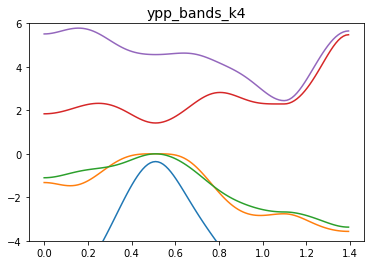

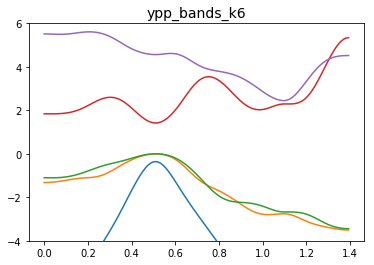

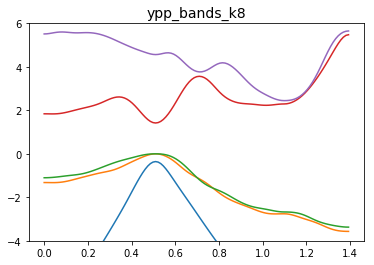

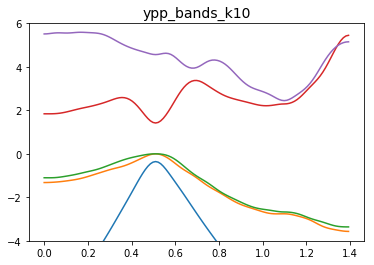

In [11]:
for k,y in ypp.items():
    kvalues = y.fetch_results(attribute='k')[0]
    bands = []
    for ind in range(1,13):
        bands.append(y.fetch_results(attribute='b%s'%ind)[0])
    for bnd in [3,5,7,9,11]:
        plt.plot(kvalues,bands[bnd])
    plt.title(y.label,size=14)
    plt.ylim((-4,6))
    plt.show()

Comparing this plots we see that the band structure seems (quite) well converged at k=8

We can identify the Gamma point on the path and compute the direct band gap for the various cases. The path is the same in all the computations so the identification of Gamma can be done only one time

In [12]:
kvalues = ypp[4].fetch_results(attribute='k')[0]
for ind,k in enumerate(kvalues):
    kx = ypp[4].fetch_results(attribute='k_x')[0][ind]
    ky = ypp[4].fetch_results(attribute='k_y')[0][ind]
    kz = ypp[4].fetch_results(attribute='k_z')[0][ind]
    if kx == 0. and ky == 0. and kz == 0.:
        gamma_position = ind
gamma_position

43

In [13]:
for k,y in ypp.items():
    kvalues = y.fetch_results(attribute='k')[0]
    bands = []
    for ind in range(1,13):
        bands.append(y.fetch_results(attribute='b%s'%ind)[0])
    Delta = bands[8][gamma_position]-bands[7][gamma_position]
    print('Gap for k = ',k,' : ','%.4f'%Delta)

Gap for k =  4  :  1.4180
Gap for k =  6  :  1.4180
Gap for k =  8  :  1.4181
Gap for k =  10  :  1.4185


We can also plot the quantities reported in other files, for instance

In [14]:
fname = 'ypp_bands_k8/ypp_bands_k_8/o-ypp_bands_k_8.magnetization_y'

In [15]:
res = C.dict_parser(fname)

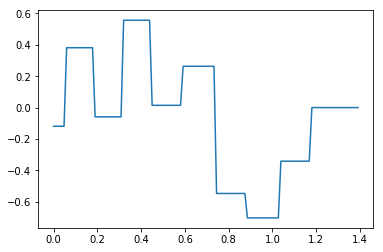

In [16]:
kvalues = res['k']
bands = []
for ind in range(1,13):
    b = 'b%s'%ind
    bands.append(res[b])
for bnd in [7]:
    plt.plot(kvalues,bands[bnd])

plt.show()